In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fraud-detection/fraudTest.csv
/kaggle/input/fraud-detection/fraudTrain.csv


In [2]:
df = pd.read_csv('../input/fraud-detection/fraudTrain.csv')

In [3]:
#We put every import here so we don't write the same line of code in different cells
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from time import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

In [4]:
#First checking for duplicate and null values:

print(df[df.duplicated() == True])
#as we can see here, we have no duplicated rows

print(df.isnull().sum())
#as we can see here, we have no null value inside any column

Empty DataFrame
Columns: [Unnamed: 0, trans_date_trans_time, cc_num, merchant, category, amt, first, last, gender, street, city, state, zip, lat, long, city_pop, job, dob, trans_num, unix_time, merch_lat, merch_long, is_fraud]
Index: []

[0 rows x 23 columns]
Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64


In [5]:
print(df.dtypes)
#intiially, checking the types of our columns

Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object


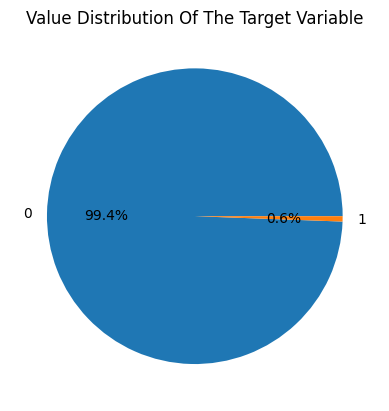

In [6]:
data = df['is_fraud'].value_counts()

plt.pie(data, labels=data.index, autopct='%1.1f%%')
plt.title("Value Distribution Of The Target Variable")
plt.show()

#Here, we know that we are dealing with an imbalanced dataset.

In [7]:
#Summary statistics for the entire dataset
df.describe()

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06
mean,6.483370e+05,4.171920e+17,7.035104e+01,4.880067e+04,3.853762e+01,-9.022634e+01,8.882444e+04,1.349244e+09,3.853734e+01,-9.022646e+01,5.788652e-03
std,3.743180e+05,1.308806e+18,1.603160e+02,2.689322e+04,5.075808e+00,1.375908e+01,3.019564e+05,1.284128e+07,5.109788e+00,1.377109e+01,7.586269e-02
min,0.000000e+00,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902779e+01,-1.666712e+02,0.000000e+00
25%,3.241685e+05,1.800429e+14,9.650000e+00,2.623700e+04,3.462050e+01,-9.679800e+01,7.430000e+02,1.338751e+09,3.473357e+01,-9.689728e+01,0.000000e+00
50%,6.483370e+05,3.521417e+15,4.752000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.456000e+03,1.349250e+09,3.936568e+01,-8.743839e+01,0.000000e+00
75%,9.725055e+05,4.642255e+15,8.314000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.359385e+09,4.195716e+01,-8.023680e+01,0.000000e+00
max,1.296674e+06,4.992346e+18,2.894890e+04,9.978300e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.371817e+09,6.751027e+01,-6.695090e+01,1.000000e+00


In [8]:
#This one is for the non fraud transactions only 
print('Summary statistics of non-fraudulent transactions:')
non_fraud_dataSet = df[df['is_fraud'] == 0]
non_fraud_dataSet.describe()

Summary statistics of non-fraudulent transactions:


,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.289169e+06,1.289169e+06,1.289169e+06,1.289169e+06,1.289169e+06,1.289169e+06,1.289169e+06,1.289169e+06,1.289169e+06,1.289169e+06,1289169.0
mean,6.484732e+05,4.172901e+17,6.766711e+01,4.880511e+04,3.853689e+01,-9.022814e+01,8.877523e+04,1.349249e+09,3.853666e+01,-9.022827e+01,0.0
std,3.741526e+05,1.308990e+18,1.540080e+02,2.689099e+04,5.075234e+00,1.375598e+01,3.018065e+05,1.283514e+07,5.109144e+00,1.376794e+01,0.0
min,0.000000e+00,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902779e+01,-1.666712e+02,0.0
25%,3.246100e+05,1.800429e+14,9.610000e+00,2.623700e+04,3.462050e+01,-9.679800e+01,7.430000e+02,1.338759e+09,3.473145e+01,-9.689853e+01,0.0
50%,6.484110e+05,3.521417e+15,4.728000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.456000e+03,1.349254e+09,3.936528e+01,-8.744091e+01,0.0
75%,9.723990e+05,4.642255e+15,8.254000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.359378e+09,4.195705e+01,-8.023853e+01,0.0
max,1.296674e+06,4.992346e+18,2.894890e+04,9.978300e+04,6.568990e+01,-6.795030e+01,2.906700e+06,1.371817e+09,6.668291e+01,-6.695090e+01,0.0


In [9]:
#This one is for the fraud transactions only
print('Summary statistics of fraudulent transactions:')
fraud_dataSet = df[df['is_fraud'] == 1]
fraud_dataSet.describe()

Summary statistics of fraudulent transactions:


,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,7.506000e+03,7.506000e+03,7506.000000,7506.000000,7506.000000,7506.000000,7.506000e+03,7.506000e+03,7506.000000,7506.000000,7506.0
mean,6.249497e+05,4.003577e+17,531.320092,48038.714229,38.663609,-89.916041,9.727676e+04,1.348389e+09,38.653901,-89.915808,1.0
std,4.010560e+05,1.276871e+18,390.560070,27265.558212,5.172289,14.278221,3.265815e+05,1.383020e+07,5.218387,14.298685,0.0
min,2.449000e+03,6.041621e+10,1.060000,1330.000000,20.027100,-165.672300,2.300000e+01,1.325466e+09,19.425114,-166.550779,1.0
25%,2.398565e+05,1.800429e+14,245.662500,24927.000000,35.056100,-96.701000,7.465000e+02,1.335744e+09,35.114671,-96.671038,1.0
50%,6.381620e+05,3.528041e+15,396.505000,46290.000000,39.433600,-86.691900,2.623000e+03,1.348872e+09,39.427008,-86.813044,1.0
75%,9.849215e+05,4.651007e+15,900.875000,71107.000000,42.073175,-79.941600,2.143700e+04,1.360021e+09,41.986902,-79.907096,1.0
max,1.295733e+06,4.992346e+18,1376.040000,99783.000000,66.693300,-68.556500,2.906700e+06,1.371787e+09,67.510267,-67.569238,1.0


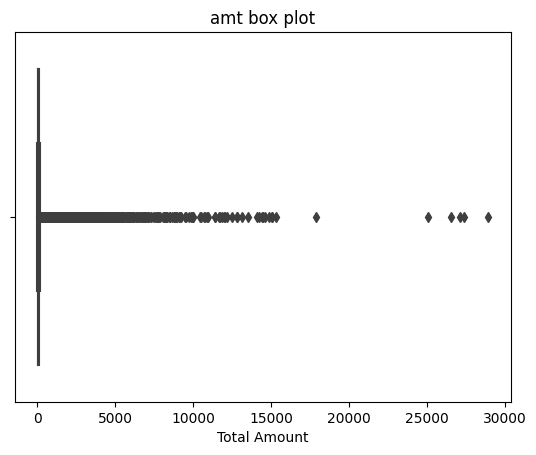

In [10]:
sns.boxplot(x = df['amt'])
plt.title('amt box plot')
plt.xlabel('Total Amount')
plt.show()

#This box plot shows that the amt values have outliers however, the summary descriptions above this box plot show that...
#...the mean of the amount column is way higher when fraudulent transactions are made so...
#... we can know these can be inherent characteristics of fraudulent transactions


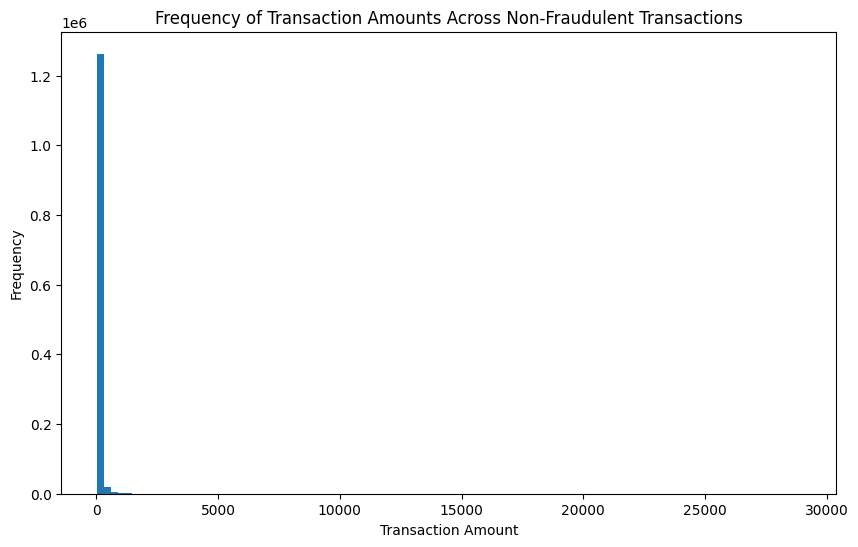

In [11]:
non_fraud_dataSet = df[df.is_fraud == 0]
data = non_fraud_dataSet['amt']
plt.figure(figsize=(10, 6))
plt.hist(data, bins = 100)
plt.title('Frequency of Transaction Amounts Across Non-Fraudulent Transactions')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

#This graph shows that the vast majority of non-fraudulent transactions are clustered around small amounts,... 
#...close to 0. The frequency drops as the transaction amount increases.

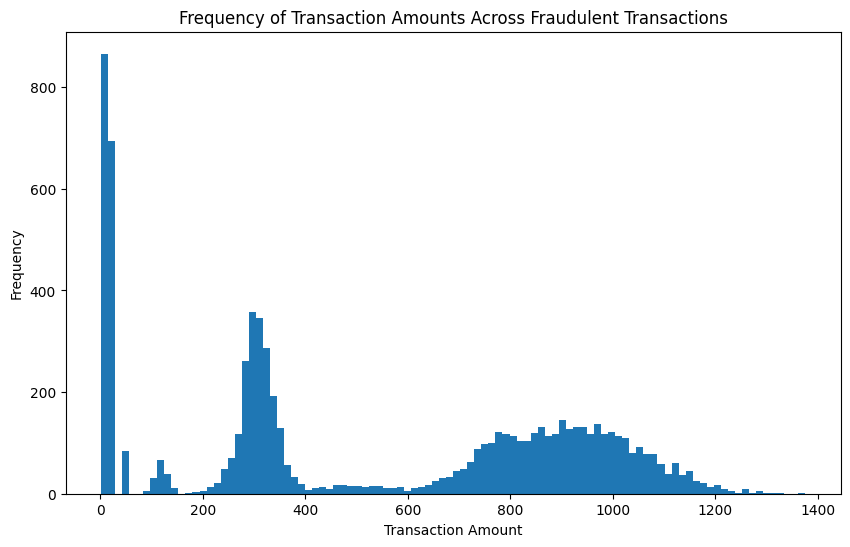

In [12]:
fraud_dataSet = df[df.is_fraud == 1]
data = fraud_dataSet['amt']
plt.figure(figsize=(10, 6))
plt.hist(data, bins = 100)
plt.title('Frequency of Transaction Amounts Across Fraudulent Transactions')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

# This graph shows that while the highest frequency of fraudulent transactions is also at amounts close to 0,...
#...there is a wider distribution of transaction amounts with noticeable frequencies between 200 and 1200.


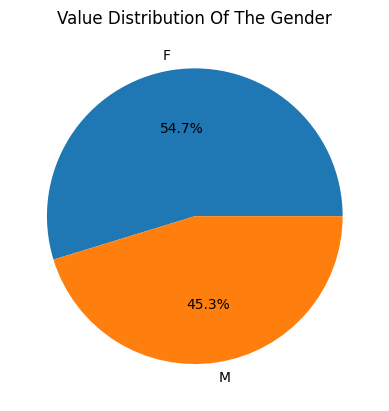

<Figure size 1000x600 with 0 Axes>

In [13]:
data = df['gender'].value_counts()

plt.pie(data, labels=data.index, autopct='%1.1f%%')
plt.title("Value Distribution Of The Gender")
plt.figure(figsize=(10, 6))
plt.show()

#Here, we can observe that the value distribution of gender are almost equal.

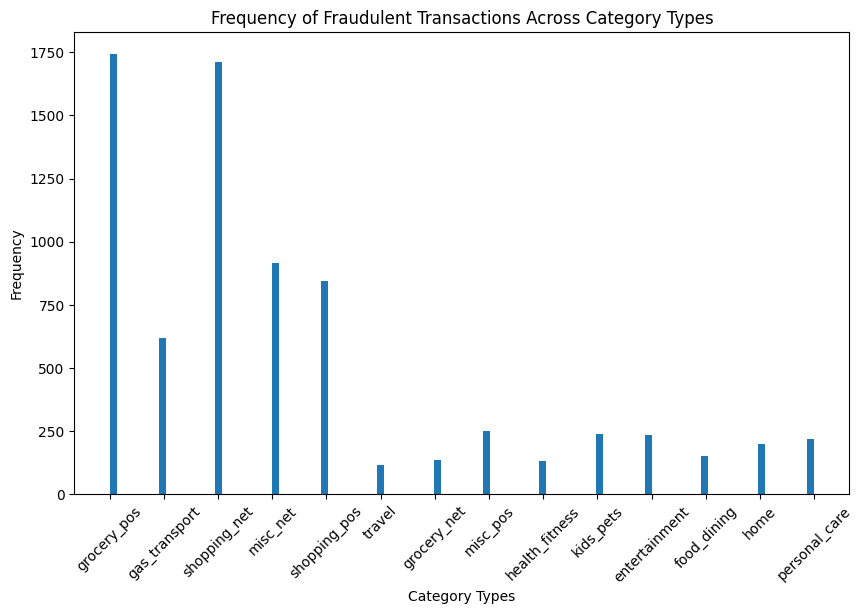

In [14]:
fraud_dataSet = df[df['is_fraud'] == 1]

data = fraud_dataSet['category']
plt.figure(figsize=(10, 6))
plt.hist(data, bins = 100)
plt.title('Frequency of Fraudulent Transactions Across Category Types')
plt.xlabel('Category Types')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.show()

#As we can observe, the categories that were mostly used for fraudulent transactions are: grocery_pos and shopping_net


In [15]:
#Feature Selection/Extraction: 

df['trans_date_trans_time']= df['trans_date_trans_time'].str[10:13]
#taking only the hour time from this format: 'M/D/YYYY  HH:MM:SS AM/PM'

df = df.rename(columns={'trans_date_trans_time': 'trans_hour'})

print(df['trans_hour'].unique()) 

[' 00' ' 01' ' 02' ' 03' ' 04' ' 05' ' 06' ' 07' ' 08' ' 09' ' 10' ' 11'
 ' 12' ' 13' ' 14' ' 15' ' 16' ' 17' ' 18' ' 19' ' 20' ' 21' ' 22' ' 23']


In [16]:
df = df.drop(columns=['cc_num', 'merchant', 'first', 'last', 'street', 'city', 'state', 'zip', 'city_pop','job', 'trans_num', 'unix_time' ])  

In [17]:
df['lat'] = abs(df['lat'] - df['merch_lat'])
df['long'] = abs(df['long'] - df['merch_long'])

df = df.rename(columns = {'long': 'long_distance', 'lat': 'lat_distance'})

df = df.drop(columns=['merch_lat'])
df = df.drop(columns=['merch_long'])

In [18]:
df['dob'] = df['dob'].str[0:4] 
#taking only the birth year from this format: 'M/D/YYYY' so we can get the age of the card holder

df['dob'] = df['dob'].astype(int) 
#turning the column to integer values so we can get the age(performing a column type transformation)

df['dob'] = 2020 - df['dob'] #because the dataset has transacions up until no more than 2020
df = df.rename(columns={'dob': 'age'})

In [19]:
#Printing entire the dataframe after feature Selection/Extraction:
print(df.head())

   Unnamed: 0 trans_hour       category     amt gender  lat_distance  \
0           0         00       misc_net    4.97      F      0.067507   
1           1         00    grocery_pos  107.23      F      0.271247   
2           2         00  entertainment  220.11      M      0.969904   
3           3         00  gas_transport   45.00      M      0.803731   
4           4         00       misc_pos   41.96      M      0.254299   

   long_distance  age  is_fraud  
0       0.870215   32         0  
1       0.024038   42         0  
2       0.107519   58         0  
3       0.447271   53         0  
4       0.830441   34         0  


In [20]:
#This part is for encoding: 
print('number of different hours: ', len(df['trans_hour'].unique()), '==>',df['trans_hour'].unique() )
#Now we can use label encoding on the trans_hour column

le=LabelEncoder()
df['trans_hour'] = le.fit_transform(df['trans_hour'])
#we then renamed the column to trans_hour

number of different hours:  24 ==> [' 00' ' 01' ' 02' ' 03' ' 04' ' 05' ' 06' ' 07' ' 08' ' 09' ' 10' ' 11'
 ' 12' ' 13' ' 14' ' 15' ' 16' ' 17' ' 18' ' 19' ' 20' ' 21' ' 22' ' 23']


In [21]:
print('number of different categories: ', len(df['category'].unique()))
#Performing binary encoding on the 'category' column
encoder = ce.BinaryEncoder(cols=['category'])

df_binary=encoder.fit_transform(df['category'])

df = pd.concat([df, df_binary], axis=1) #this line is to add the new encoded columns inside the dataframe

df = df.drop(columns=['category'])#dropping the main category column after adding the new encoded columns inside df

number of different categories:  14


In [22]:
print('number of different genders: ', len(df['gender'].unique()), '==>', df['gender'].unique() )
#Now we can use one hot encoding on the gender column 

df = pd.get_dummies(df, columns=['gender'], prefix = 'gender')

number of different genders:  2 ==> ['F' 'M']


In [23]:
#checking the types of all the columns after done with feature selection/extraction, encoding, etc...
print(df.dtypes)
print(df.head())

Unnamed: 0         int64
trans_hour         int64
amt              float64
lat_distance     float64
long_distance    float64
age                int64
is_fraud           int64
category_0         int64
category_1         int64
category_2         int64
category_3         int64
gender_F            bool
gender_M            bool
dtype: object
   Unnamed: 0  trans_hour     amt  lat_distance  long_distance  age  is_fraud  \
0           0           0    4.97      0.067507       0.870215   32         0   
1           1           0  107.23      0.271247       0.024038   42         0   
2           2           0  220.11      0.969904       0.107519   58         0   
3           3           0   45.00      0.803731       0.447271   53         0   
4           4           0   41.96      0.254299       0.830441   34         0   

   category_0  category_1  category_2  category_3  gender_F  gender_M  
0           0           0           0           1      True     False  
1           0           0     

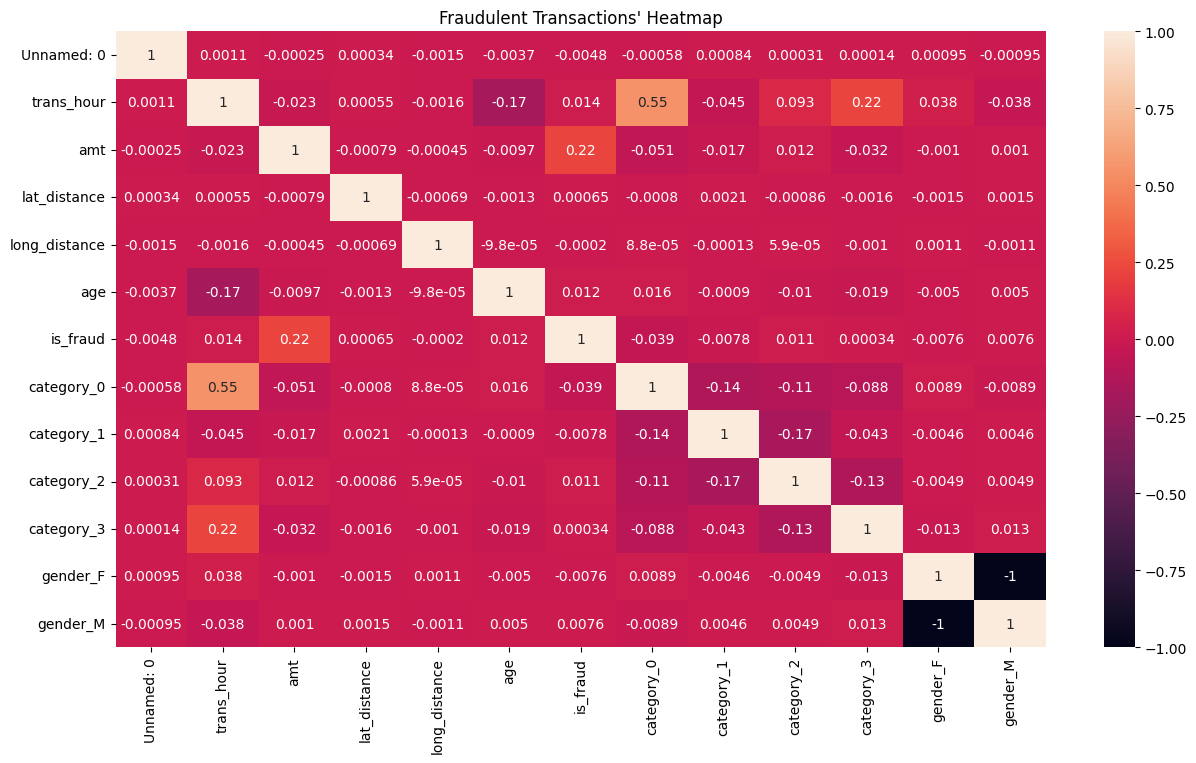

In [24]:
#this part is for seeing correlations. (Checking heatmap after being done with everything)

df_test = df.corr() 
plt.figure(figsize=(15, 8))
sns.heatmap(df_test, annot=True)
plt.title("Fraudulent Transactions' Heatmap")
plt.show()

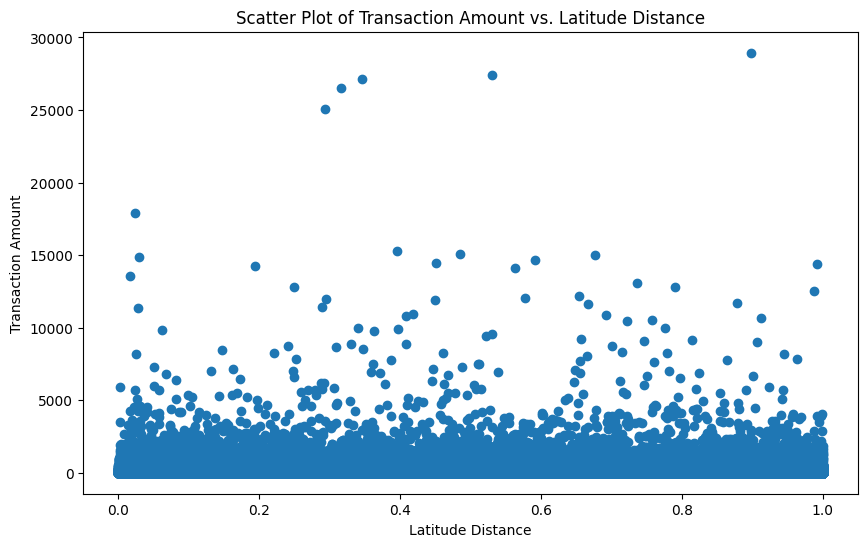

In [25]:
#Some additional Data visualizations: (That were added during the final phase of the project)

plt.figure(figsize=(10, 6))
plt.scatter(df['lat_distance'], df['amt'])
plt.title('Scatter Plot of Transaction Amount vs. Latitude Distance')
plt.xlabel('Latitude Distance')
plt.ylabel('Transaction Amount')
plt.show()

#The scatter plot displays a cluster of data points mostly concentrated at the lower end of the transaction amount axis,... 
#...suggesting that smaller transactions are more common regardless of latitude distance.

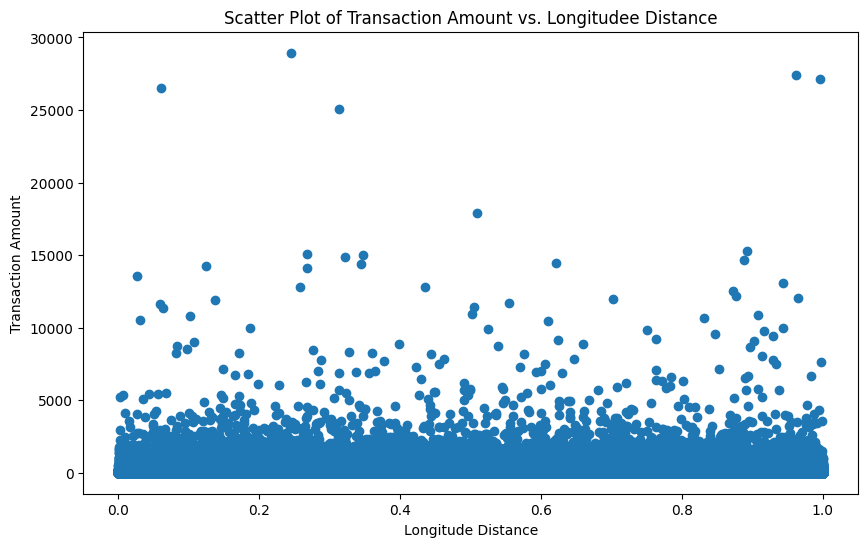

In [26]:
plt.figure(figsize=(10, 6))
plt.scatter(df['long_distance'], df['amt'])
plt.title('Scatter Plot of Transaction Amount vs. Longitudee Distance')
plt.xlabel('Longitude Distance')
plt.ylabel('Transaction Amount')
plt.show()

#For this one, we can say that it is the same as above but now smaller transactions are more common regardless of their...
#...longitude distance

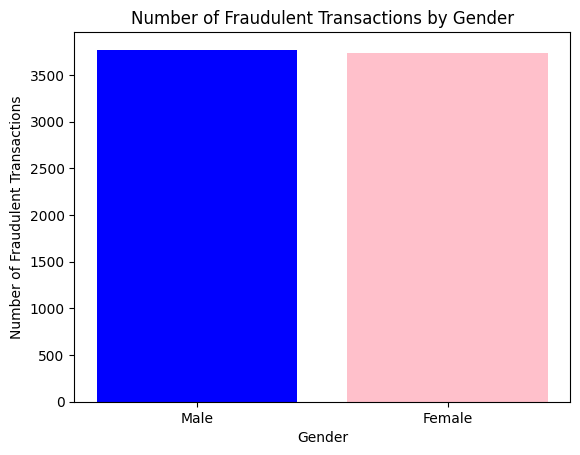

In [27]:
#Fraudulent transcations with respect to gender

maleFraud = df[(df['gender_M'] == 1) & (df['is_fraud'] == 1)]
maleFraud_count = df[(df['gender_M'] == 1) & (df['is_fraud'] == 1)]['is_fraud'].sum()

femaleFraud = df[(df['gender_F'] == 1) & (df['is_fraud'] == 1)]
femaleFraud_count = df[(df['gender_F'] == 1) & (df['is_fraud'] == 1)]['is_fraud'].sum()

gender = ['Male', 'Female']
fraud_counts = [maleFraud_count, femaleFraud_count]

plt.bar(gender, fraud_counts, color=['blue', 'pink'])
plt.title('Number of Fraudulent Transactions by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Fraudulent Transactions')
plt.show()

#The bar chart illustrates the number of fraudulent transactions by gender, ... 
#...showing that the counts for males and females are fairly similar, with a slightly higher number for one gender.


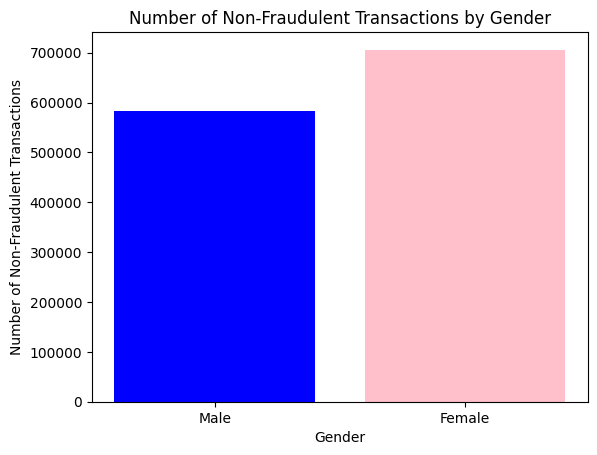

In [28]:
#non-Fraudulent transcations with respect to gender

#Include only non-fraudulent transactions
non_fraudulent_transactions = df[df['is_fraud'] == 0]

male_non_fraud_count = non_fraudulent_transactions[non_fraudulent_transactions['gender_M'] == 1]['is_fraud'].count()
female_non_fraud_count = non_fraudulent_transactions[non_fraudulent_transactions['gender_F'] == 1]['is_fraud'].count()

gender = ['Male', 'Female']
non_fraud_counts = [male_non_fraud_count, female_non_fraud_count]

plt.bar(gender, non_fraud_counts, color=['blue', 'pink'])
plt.title('Number of Non-Fraudulent Transactions by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Non-Fraudulent Transactions')
plt.show()

#The bar chart illustrates the number of non-fraudulent transactions by gender, ... 
#...showing that the count  for one gender is significantly greater than the other one.


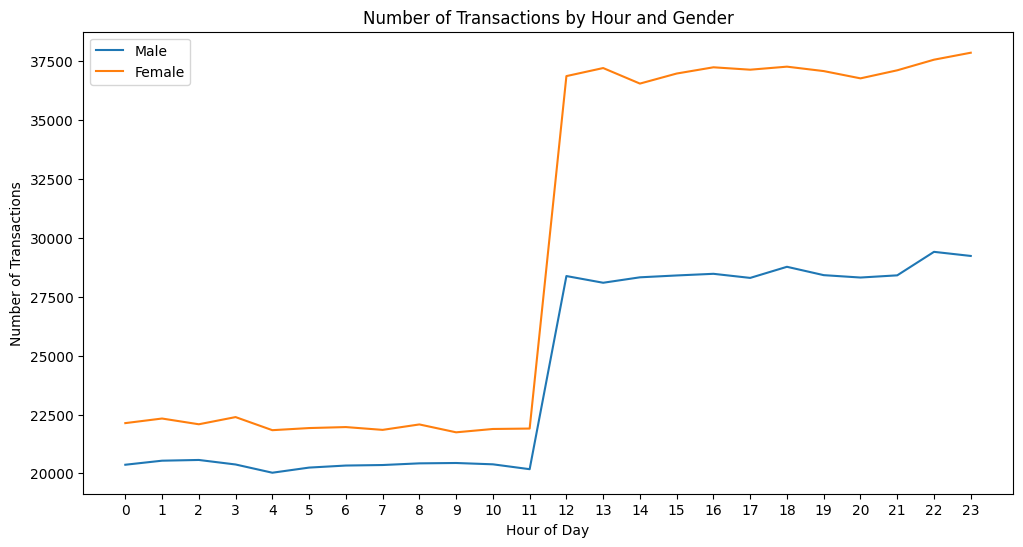

In [29]:
hourly_transactions_male = df[df['gender_M'] == 1].groupby('trans_hour').size()
hourly_transactions_female = df[df['gender_F'] == 1].groupby('trans_hour').size()


plt.figure(figsize=(12, 6))
plt.plot(hourly_transactions_male.index, hourly_transactions_male.values, label='Male')
plt.plot(hourly_transactions_female.index, hourly_transactions_female.values, label='Female')


plt.title('Number of Transactions by Hour and Gender')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Transactions')
plt.xticks(range(0, 24))  # because we have a 24hr format

plt.legend() #added on the top left, for making visualization easier

plt.show()


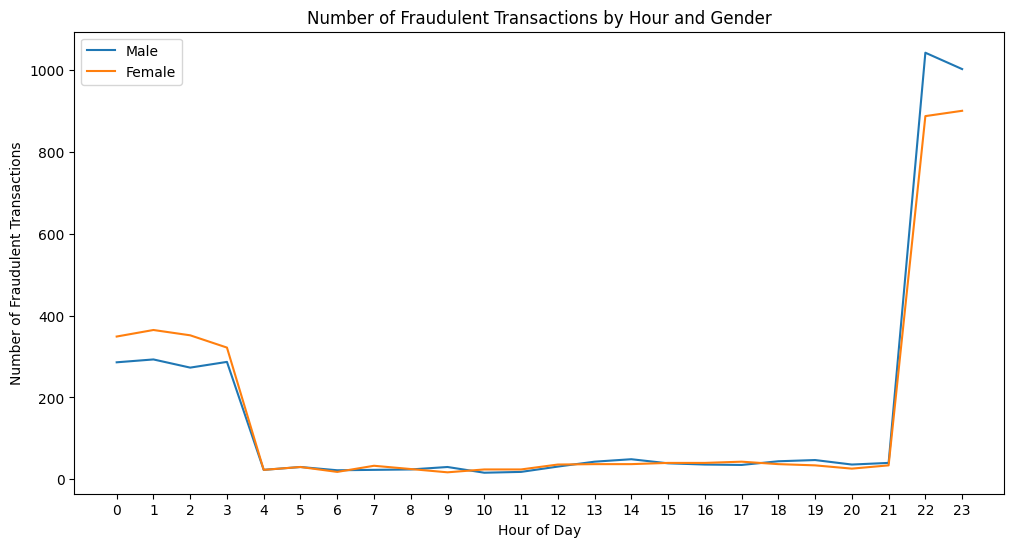

In [30]:
#Filtering to only fraudulent trasactions
fraud_df = df[df['is_fraud'] == 1]

hourly_fraud_male = fraud_df[fraud_df['gender_M'] == 1].groupby('trans_hour').size()
hourly_fraud_female = fraud_df[fraud_df['gender_F'] == 1].groupby('trans_hour').size()

plt.figure(figsize=(12, 6))
plt.plot(hourly_fraud_male.index, hourly_fraud_male.values, label='Male')
plt.plot(hourly_fraud_female.index, hourly_fraud_female.values, label='Female')

plt.title('Number of Fraudulent Transactions by Hour and Gender')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Fraudulent Transactions')
plt.xticks(range(0, 24))  # because we have a 24 hr format
plt.legend()

plt.show()


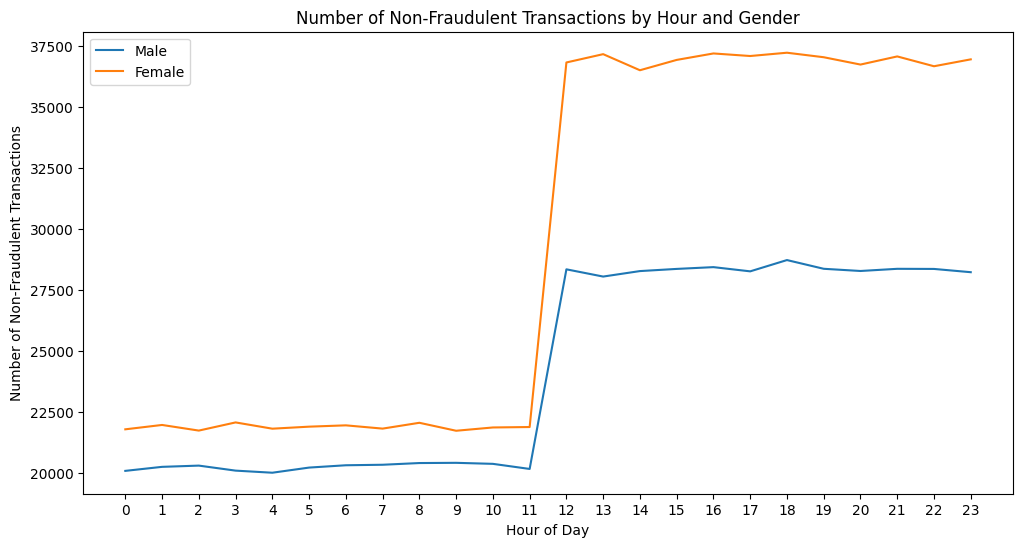

In [31]:
#Filtering to only non-fraudulent transactions
non_fraud_df = df[df['is_fraud'] == 0]

hourly_non_fraud_male = non_fraud_df[non_fraud_df['gender_M'] == 1].groupby('trans_hour').size()
hourly_non_fraud_female = non_fraud_df[non_fraud_df['gender_F'] == 1].groupby('trans_hour').size()

plt.figure(figsize=(12, 6))
plt.plot(hourly_non_fraud_male.index, hourly_non_fraud_male.values, label='Male')
plt.plot(hourly_non_fraud_female.index, hourly_non_fraud_female.values, label='Female')

plt.title('Number of Non-Fraudulent Transactions by Hour and Gender')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Non-Fraudulent Transactions')
plt.xticks(range(0, 24))  #because we have a 24 hour format
plt.legend()

plt.show()

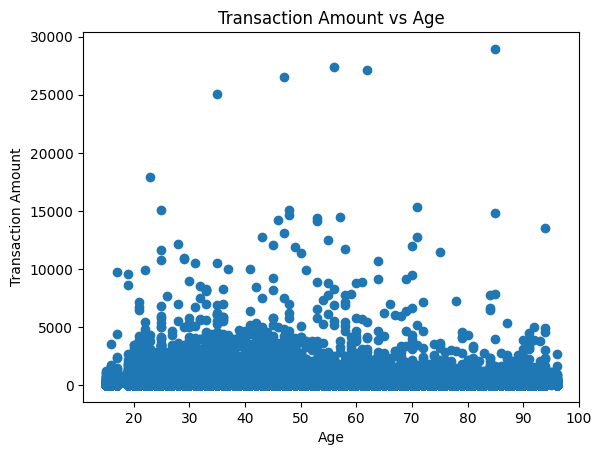

In [32]:
#Relationship between (transaction amount of every purchase) and (age)

plt.scatter(df['age'], df['amt'])
plt.title('Transaction Amount vs Age')
plt.xlabel('Age')
plt.ylabel('Transaction Amount')
plt.show()

# The majority of transactions appear to be clustered at lower transaction amounts, ...
#...irrespective of age, with a few outliers representing higher transaction amounts. 


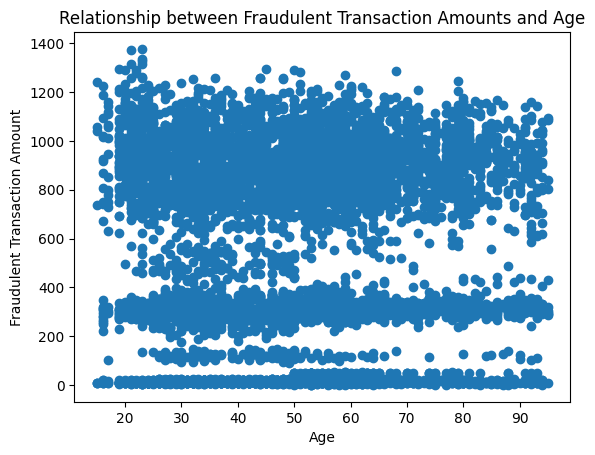

In [33]:
#Relationship between (fraudulent transaction amounts of every purchase) and (age)

#Including only fraudulent transactions
fraudulent_transactions = df[df['is_fraud'] == 1]

plt.scatter(fraudulent_transactions['age'], fraudulent_transactions['amt'])
plt.title('Relationship between Fraudulent Transaction Amounts and Age')
plt.xlabel('Age')
plt.ylabel('Fraudulent Transaction Amount')
plt.show()

#The scatter plot primarily illustrates that fraudulent transactions are predominantly lower in amount,...
#...with the bulk of data points clustered near the bottom of the graph. This trend is consistent across all age groups. 

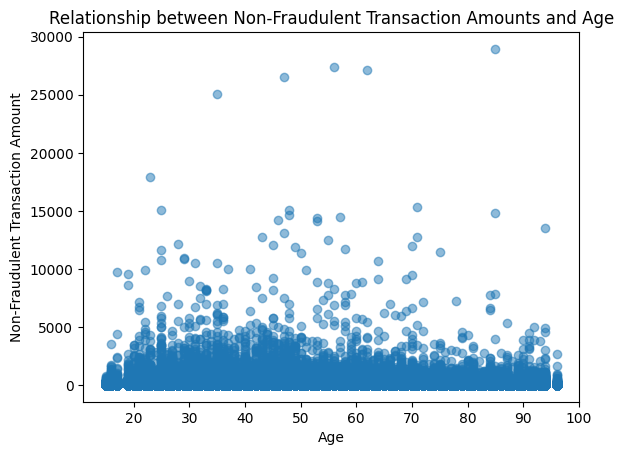

In [34]:
#Relationship between (non-fraudulent transaction amounts of every purchase) and (age)

#Including only non-fraudulent transactions
non_fraudulent_transactions = df[df['is_fraud'] == 0]

plt.scatter(non_fraudulent_transactions['age'], non_fraudulent_transactions['amt'], alpha=0.5)
plt.title('Relationship between Non-Fraudulent Transaction Amounts and Age')
plt.xlabel('Age')
plt.ylabel('Non-Fraudulent Transaction Amount')
plt.show()

#The majority of transactions are concentrated at the lower end of the transaction amount spectrum, with a dense clustering...
#of points near the bottom of the graph, indicating that non-fraudulent transactions are typically of smaller amounts across all age groups. 

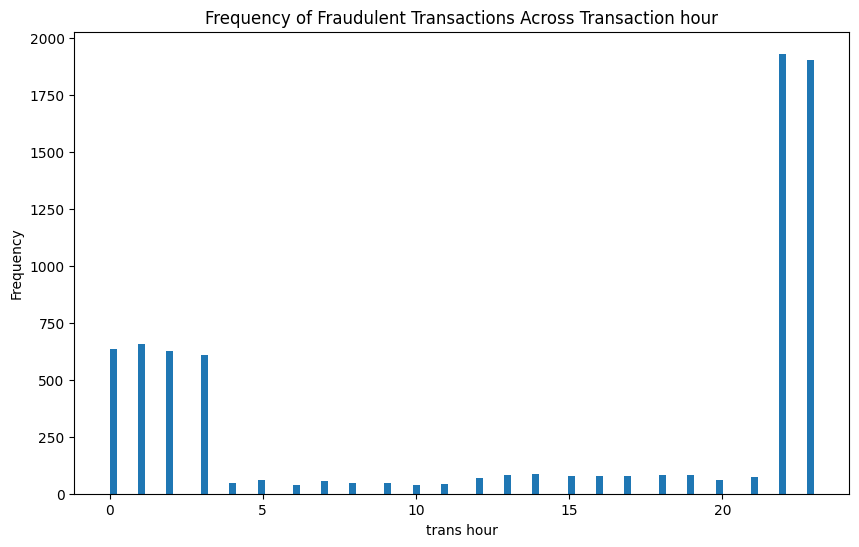

In [35]:
fraud_dataSet = df[df['is_fraud'] == 1]
data = fraud_dataSet['trans_hour']
plt.figure(figsize=(10, 6))
plt.hist(data, bins = 100)
plt.title('Frequency of Fraudulent Transactions Across Transaction hour')
plt.xlabel('trans hour')
plt.ylabel('Frequency')
plt.show()
#we observe that most of the fraudulent transactions done are during 10PM (22) and 11PM(23).


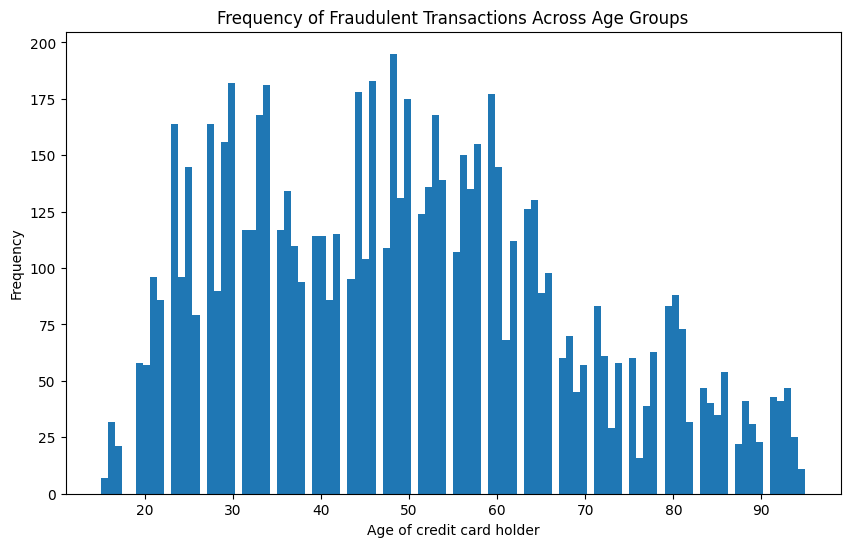

In [36]:
fraud_dataSet = df[df.is_fraud == 1]
data = fraud_dataSet['age']
plt.figure(figsize=(10, 6))
plt.hist(data, bins = 100)
plt.title('Frequency of Fraudulent Transactions Across Age Groups')
plt.xlabel('Age of credit card holder')
plt.ylabel('Frequency')
plt.show()
#we observe that indviduals within the ages of 30-60 have the most fraudulent transactions.


In [38]:
def Plot_Auc_Roc_Curve(X_test, y_test):
    """This function is for Visualizing the AUC-ROC curve"""
    # Calculate ROC curve and AUC
    probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

In [39]:
#This function is for calculating our evaluation metrics
#This function was made so we dont rewrite this entire code for every model

def calculate_evaluation_metrics(y_true, y_pred):
    """This function is for calculating our evaluation metrics"""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    auc_roc = roc_auc_score(y_true, y_pred)
    
    return accuracy, precision, recall, f1, auc_roc

In [40]:
#This function is for printing the values of all our evaluation metrics
#This function was made so we dont rewrite this entire code for every model

def print_evaluation_metrics(accuracy, precision, recall, f1, auc_roc):
    """This function is for printing the values of all our evaluation metrics"""
    print('Test Accuracy:', accuracy)
    print('Test Precision:', precision)
    print('Test Recall:', recall)
    print('Test F1 Score:', f1)
    print('Test AUC ROC:', auc_roc)

In [41]:
def evaluation_metrics(test_accuracy, test_precision, test_recall, test_f1, test_auc_roc):
    
    """This function is for putting all the evaluation metrics on a chart after training each model"""
    #Evaluation metrics and their corresponding values
    metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "AUC ROC"]
    values = [test_accuracy, test_precision, test_recall, test_f1, test_auc_roc]

    # Create a vertical bar chart
    plt.figure(figsize=(8, 6))
    plt.bar(metrics, values, color='skyblue')
    plt.ylabel('Values')
    plt.xlabel('Evaluation Metrics')
    plt.title('Model Evaluation Metrics')

    # Display the values on top of the bars
    for i, value in enumerate(values):
        plt.text(i, value + 0.01, f'{value:.4f}', ha='center', va='bottom', fontsize=12)

    plt.xticks(rotation=45)  # Rotate the metric names for better readability

    plt.tight_layout()
    plt.show()

In [42]:
def show_confusion_matrix(y_test, y_test_pred):
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [43]:
X = df.drop(columns='is_fraud',axis=1)
y = df['is_fraud']

Start_Time = time()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
model = LogisticRegression()
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
End_Time = time()

#Calculate evaluation metrics for test data
test_accuracy, test_precision, test_recall, test_f1, test_auc_roc = calculate_evaluation_metrics(y_test, y_test_pred)

#Printing the evaluation metrics
print_evaluation_metrics(test_accuracy, test_precision, test_recall, test_f1, test_auc_roc)

print('time: ', End_Time - Start_Time)

Test Accuracy: 0.9937301254746107
Test Precision: 0.5212713292561358
Test Recall: 0.5019655628363985
Test F1 Score: 0.502494255228135
Test AUC ROC: 0.5019655628363985
time:  5.911311388015747


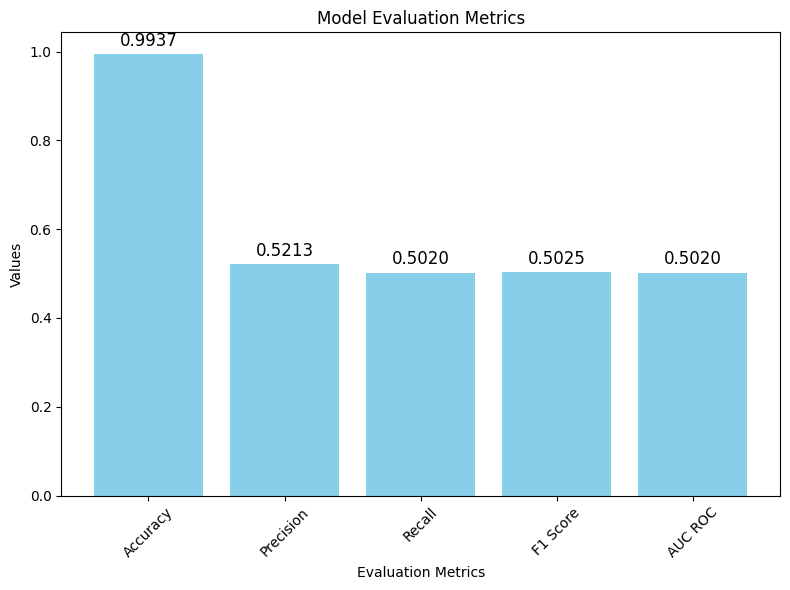

In [44]:
#The comparison of the evaluation metrics for logistic regression on the full dataset.
evaluation_metrics(test_accuracy, test_precision, test_recall, test_f1, test_auc_roc)


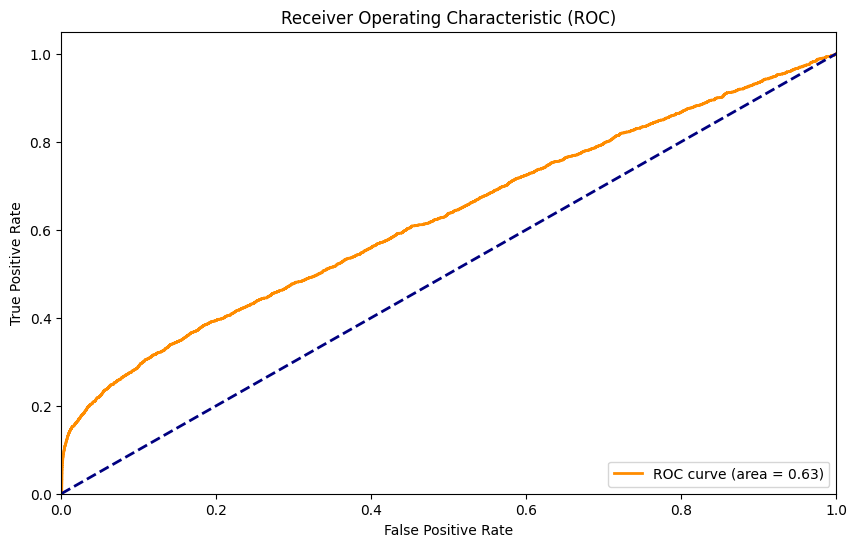

In [45]:
#The AUC ROC curve of logistic regression on the full dataset.
Plot_Auc_Roc_Curve(X_test, y_test)


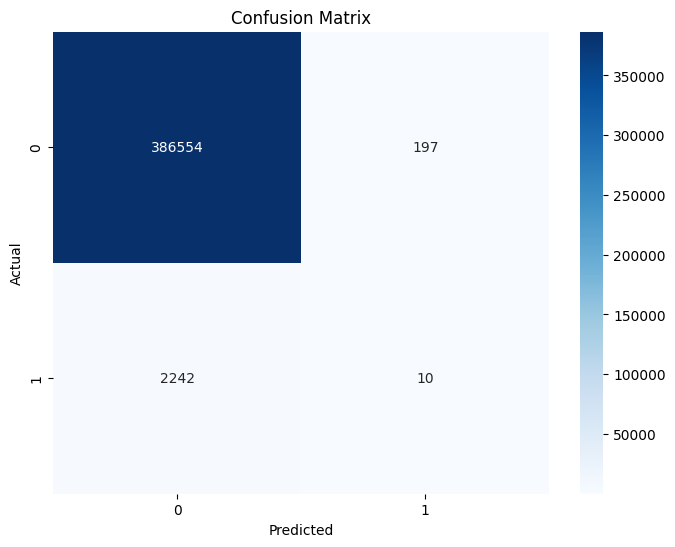

In [46]:
show_confusion_matrix(y_test, y_test_pred)


In [47]:
#Logistic Regression on the split dataset (7.5k fraud and 7.5k random non-fraud)

fraud_dataSet = df[df.is_fraud == 1]
legit_dataSet = df[df.is_fraud == 0]
# building a legit dataset in the length of the frauds (7506), so it will be 7506 frauds and 7506 legits
legit_sample = legit_dataSet.sample(n=7506)

new_dataset = pd.concat([legit_sample,fraud_dataSet], axis=0)

X = new_dataset.drop(columns='is_fraud',axis=1)
y = new_dataset['is_fraud']

Start_Time = time()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, stratify=y, random_state=42) #test_size=0.2, random_state=2
model = LogisticRegression()
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
End_Time = time()

#Calculate evaluation metrics for test data
test_accuracy, test_precision, test_recall, test_f1, test_auc_roc = calculate_evaluation_metrics(y_test, y_test_pred)

#Printing the evaluation metrics
print_evaluation_metrics(test_accuracy, test_precision, test_recall, test_f1, test_auc_roc)

print('time: ', End_Time - Start_Time)

Test Accuracy: 0.8439165186500888
Test Precision: 0.854160308559814
Test Recall: 0.8439165186500888
Test F1 Score: 0.8427796519714885
Test AUC ROC: 0.8439165186500888
time:  0.07470560073852539


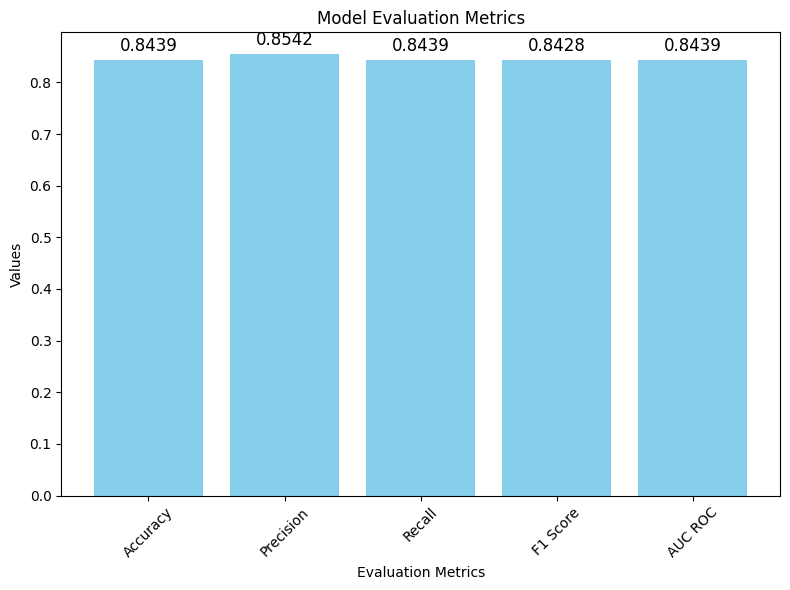

In [48]:
evaluation_metrics(test_accuracy, test_precision, test_recall, test_f1, test_auc_roc)

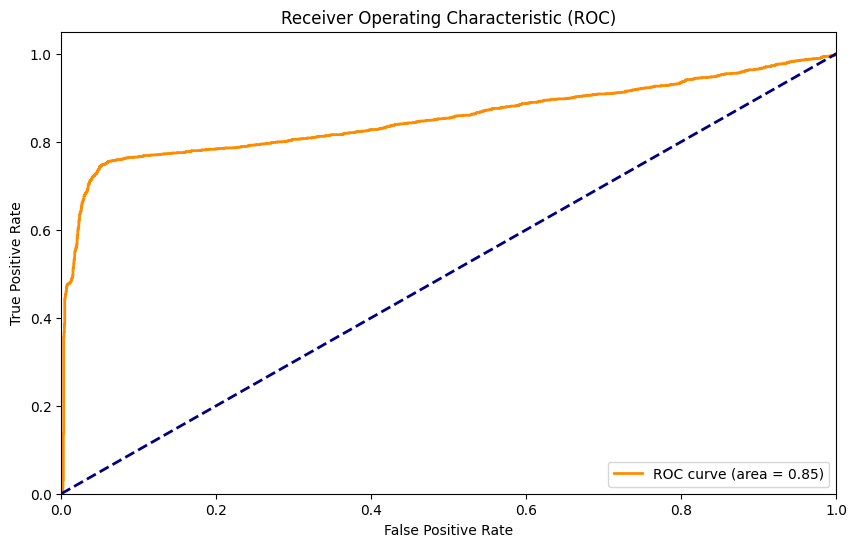

In [49]:
Plot_Auc_Roc_Curve(X_test, y_test)

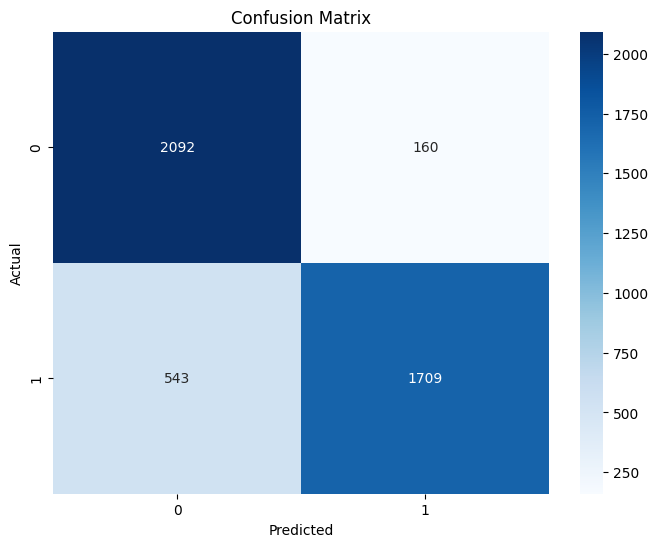

In [50]:
show_confusion_matrix(y_test, y_test_pred)


In [51]:
X = df.drop(columns='is_fraud',axis=1)
y = df['is_fraud']

Start_Time = time()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, stratify=y, random_state=42)
model = tree.DecisionTreeClassifier(min_samples_split=2, max_depth=2, min_samples_leaf=2, random_state=42)
model.fit(X_train,y_train)
y_test_pred = model.predict(X_test)
End_Time = time()

#Calculate evaluation metrics for test data
test_accuracy, test_precision, test_recall, test_f1, test_auc_roc = calculate_evaluation_metrics(y_test, y_test_pred)

#Printing the evaluation metrics
print_evaluation_metrics(test_accuracy, test_precision, test_recall, test_f1, test_auc_roc)

print('time: ', End_Time - Start_Time)

Test Accuracy: 0.9954833253213986
Test Precision: 0.8871916310373085
Test Recall: 0.6533865219838231
Test F1 Score: 0.7191782566686453
Test AUC ROC: 0.6533865219838231
time:  3.9603192806243896


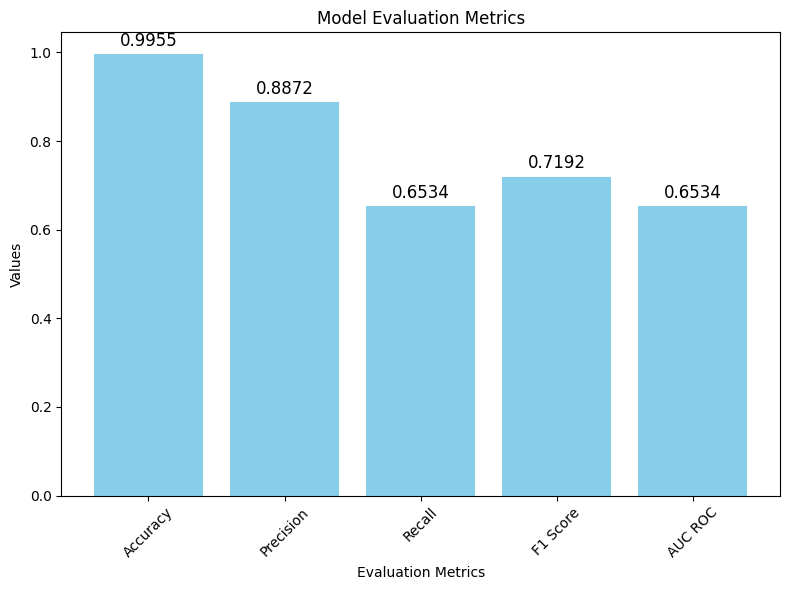

In [52]:
evaluation_metrics(test_accuracy, test_precision, test_recall, test_f1, test_auc_roc)

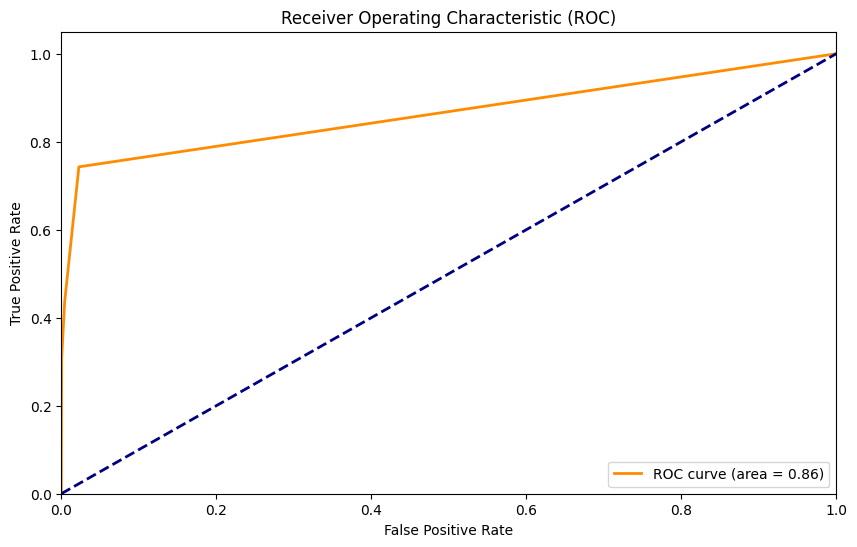

In [53]:
Plot_Auc_Roc_Curve(X_test, y_test)

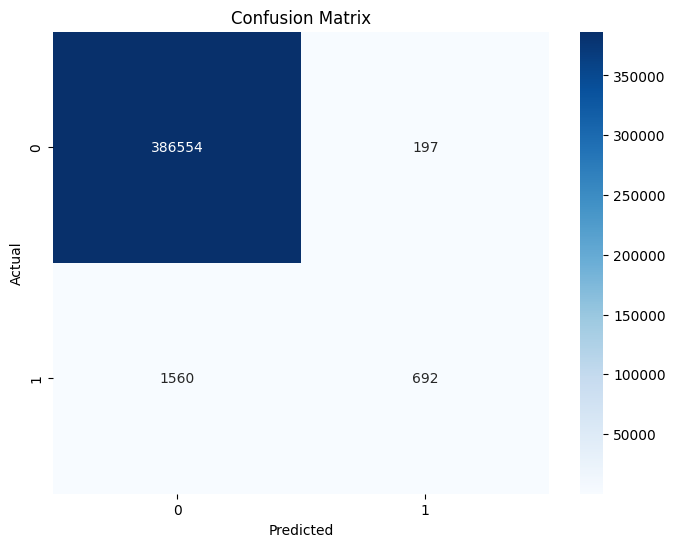

In [54]:
show_confusion_matrix(y_test, y_test_pred)

In [ ]:
#Hyper parameter tuning on random forest for the split dataset (7.5k fraud and 7.5k random non-fraud): 
Start_Time = time()

param_grid = {
'n_estimators': [1,10, 100, 200, 300],
 'max_depth': [2, 4, 10, 20, 30],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': range(1,10)
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)
best_rf = grid_search.best_estimator_
# Check performance on the test set

End_Time = time()

accuracy = best_rf.score(X_test, y_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test set accuracy of the best model: {accuracy}")
print('time: ', End_Time-Start_Time)

#2025 is the number of times the algorithm is runnning

Fitting 3 folds for each of 675 candidates, totalling 2025 fits
